In [109]:
import pandas as pd
import numpy as np
import cv2
import os
import re
import random

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt

import pickle
import json
import sys
sys.path.append('..')
import utils

IMAGE_SIZE = 1024
DATASET_PATH = '../mvtec_anomaly_detection_data'

In [110]:
annotations = utils.annotate_dataset(DATASET_PATH)
utils.create_annotation_files(annotations)

Found 15 detection objects.
Detection objects: ['bottle', 'cable', 'capsule', 'carpet', 'grid', 'hazelnut', 'leather', 'metal_nut', 'pill', 'screw', 'tile', 'toothbrush', 'transistor', 'wood', 'zipper']
Annotating: bottle (1/15)
Found 3 classes in ../mvtec_anomaly_detection_data\bottle\ground_truth
Classes: ['broken_large', 'broken_small', 'contamination']
Annotating: cable (2/15)
Found 8 classes in ../mvtec_anomaly_detection_data\cable\ground_truth
Classes: ['bent_wire', 'cable_swap', 'combined', 'cut_inner_insulation', 'cut_outer_insulation', 'missing_cable', 'missing_wire', 'poke_insulation']
Annotating: capsule (3/15)
Found 5 classes in ../mvtec_anomaly_detection_data\capsule\ground_truth
Classes: ['crack', 'faulty_imprint', 'poke', 'scratch', 'squeeze']
Annotating: carpet (4/15)
Found 5 classes in ../mvtec_anomaly_detection_data\carpet\ground_truth
Classes: ['color', 'cut', 'hole', 'metal_contamination', 'thread']
Annotating: grid (5/15)
Found 5 classes in ../mvtec_anomaly_detecti

In [111]:
def inv_dict(d):
    return dict((v, k) for k, v in d.items())

to_load = 'transistor'

object_dict = utils.get_object_dict(DATASET_PATH)
class_dict = utils.get_class_dict(DATASET_PATH, to_load)

anot = inv_dict(object_dict)

dataset = utils.load_annotation_file(f'{anot[to_load]}')
random.shuffle(dataset)
train_ds, test_ds, val_ds = utils.train_test_split_annotations(dataset, 0.8, 0)

In [112]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [113]:
class MVTEC_Dataset(Dataset):
    def __init__(self, dataset, transforms=None):
        super().__init__()       
        
        self.dataset = dataset
        self.transforms = transforms
        
    def __getitem__(self, index: int):
        data = self.dataset[index]
        
        image = cv2.imread(data[2])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        
        bbox = list(data[1])
        bbox[0] = bbox[0] * IMAGE_SIZE
        bbox[1] = bbox[1] * IMAGE_SIZE
        bbox[2] = bbox[2] * IMAGE_SIZE + bbox[0]
        bbox[3] = bbox[3] * IMAGE_SIZE + bbox[1]
        bbox = [int(x) for x in bbox]
        area = bbox[2] * bbox[3]
        
        labels = torch.as_tensor([int(data[0])], dtype=torch.int64)
        
        iscrowd = torch.zeros([0], dtype=torch.int64)
        
        target = {}
        target['boxes'] = torch.Tensor([bbox])
        target['labels'] = labels
        # target['masks'] = None
        target['image_id'] = torch.tensor([index])
        target['area'] = torch.Tensor([area])
        target['iscrowd'] = iscrowd
        
        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
        else:
            transform = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor()
            ])
            image = transform(image)
        
        return image, target, index
    
    def __len__(self) -> int:
        return len(self.dataset)

In [114]:
# Albumentations
def get_train_transform():
    return A.Compose([
        A.Flip(0.5),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [115]:
# load a model; pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

In [116]:
num_classes = len(class_dict)

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [117]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [118]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = MVTEC_Dataset(train_ds, None)
test_dataset = MVTEC_Dataset(test_ds, None)
val_dataset = MVTEC_Dataset(val_ds, None)

train_data_loader = DataLoader(
    train_dataset,
    batch_size=2,
    shuffle=True,
    collate_fn=collate_fn
)

"""
test_data_loader = DataLoader(
    train_dataset,
    batch_size=2,
    shuffle=True,
    collate_fn=collate_fn
)
"""

valid_data_loader = DataLoader(
    test_dataset,
    batch_size=2,
    shuffle=True,
    collate_fn=collate_fn
)

In [119]:
images, targets, image_ids = next(iter(train_data_loader))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

In [120]:
boxes = targets[1]['boxes'].cpu().numpy().astype(np.int32)
sample = images[1]

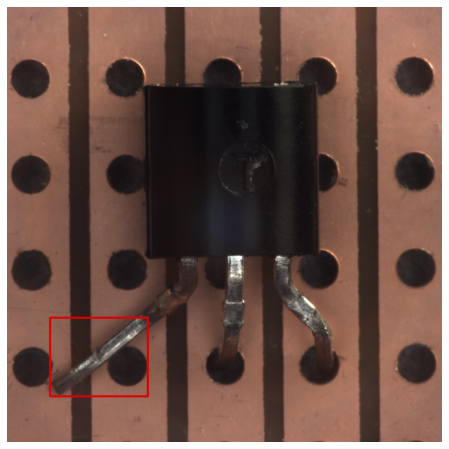

In [121]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

sample = np.array(torchvision.transforms.ToPILImage()(sample))

for box in boxes:
    cv2.rectangle(sample,
        (box[0], box[1]),
        (box[2], box[3]),
        (220, 0, 0), 3)
    
ax.set_axis_off()
ax.imshow(sample)

In [122]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
lr_scheduler = None

num_epochs = 20

In [123]:
loss_hist = Averager()
itr = 1

for epoch in range(num_epochs):
    loss_hist.reset()
    
    for images, targets, image_ids in train_data_loader:
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_hist.send(loss_value)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if itr % 50 == 0:
            print(f"Iteration #{itr} loss: {loss_value}")

        itr += 1
    
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()

    print(f"Epoch #{epoch} loss: {loss_hist.value}")   

Epoch #0 loss: 0.30603489791974425
Epoch #1 loss: 0.15669847023673356
Epoch #2 loss: 0.16906629665754735
Iteration #50 loss: 0.07626120746135712
Epoch #3 loss: 0.13948353519663215
Epoch #4 loss: 0.13513029681053013
Epoch #5 loss: 0.13262554333778098
Iteration #100 loss: 0.14151564240455627
Epoch #6 loss: 0.14078187523409724
Epoch #7 loss: 0.12234877664013766
Epoch #8 loss: 0.11543035320937634
Iteration #150 loss: 0.14438292384147644
Epoch #9 loss: 0.09725358779542148
Epoch #10 loss: 0.0992604794446379
Epoch #11 loss: 0.10085767414420843
Iteration #200 loss: 0.07820331305265427
Epoch #12 loss: 0.08260585319658276
Epoch #13 loss: 0.07788168518891325
Epoch #14 loss: 0.058479733859712724
Iteration #250 loss: 0.06727956235408783
Epoch #15 loss: 0.05857723788358271
Epoch #16 loss: 0.050054295748850564
Epoch #17 loss: 0.046348714604391716
Iteration #300 loss: 0.026578471064567566
Epoch #18 loss: 0.046206448847442516
Epoch #19 loss: 0.0460561357322149


In [139]:
images, targets, image_ids = next(iter(valid_data_loader))

In [140]:
images = list(img.to(device) for img in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

In [141]:
boxes = targets[1]['boxes'].cpu().numpy().astype(np.int32)
sample = images[1]

In [142]:
model.eval()
cpu_device = torch.device("cpu")

outputs = model(images)
outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]

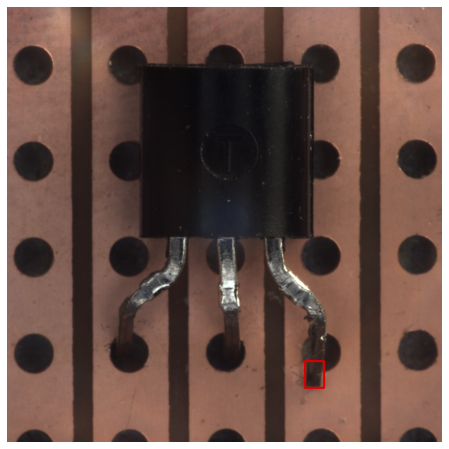

In [143]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

sample = np.array(torchvision.transforms.ToPILImage()(sample))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)
    
ax.set_axis_off()
ax.imshow(sample)